In [1]:
import torch
import argparse
import random
import math
from torch.utils import data
from torchvision import datasets, transforms

from J_Model import PCModel
import J_optim as optim
import J_utils as utils

from PIL import Image
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
from copy import copy
from time import perf_counter
from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd

from stimuli_data import *
from image_net_data import *

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
default_font_size = 18
plt.rcParams.update({'font.size': default_font_size})

In [4]:
# ====================================================================================
#
# Global Parameters and Settings
#
# ====================================================================================
parser = argparse.ArgumentParser(description='Predictive Coding')

# dataset params
parser.add_argument('--batch-size', type=int, default=64,
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000,
                    help='input batch size for testing (default: 1000)')

# optim params
parser.add_argument('--lr', type=float, default=1e-4, help='learning rate')
parser.add_argument('--epoch', type=int, default=9, help='epochs for training') #12

# inference params
parser.add_argument('--infer-lr', type=float, default=0.005, help='Inference learning rate')
parser.add_argument('--infer-iter', type=int, default=500, help='Iteration for inference') #500
parser.add_argument('--test-iter', type=int, default=500, help='Iteration for testing') #2000
parser.add_argument('--test-infer-iter', type=int, default=20000, help='Iteration for testing') #20000
parser.add_argument('--test-lr', type=int, default=0.005, help='Iteration for testing')

# convergence tolerance
parser.add_argument('--train-convergence-norm', type=str, default="L1", help="Norm for measuring convergence")
parser.add_argument('--train-convergence-tolerance', type=float, default=1e-10, help="Tolerance for measuring convergence")
parser.add_argument('--test-convergence-norm', type=str, default="L1", help="Norm for measuring convergence")
parser.add_argument('--test-convergence-tolerance', type=float, default=1e-4, help="Tolerance for measuring convergence")

# experiment params
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
parser.add_argument('--test-every', type=int, default=13, help='Test Cycle regards to Epoch ')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')

# args = parser.parse_args()
args, unknown = parser.parse_known_args()

# Gpu Setting
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Misc. Setting
# torch.manual_seed(args.seed)
torch.manual_seed(random.randint(0,1024))

In [5]:
population_size = 45
networks = [PCModel(
    nodes=[2, 100, 300, 6800], #[2, 100, 300, 6800]
    mu_dt=args.infer_lr,
    act_fn=utils.Tanh()) for i in range(population_size)]
for model_idx, model in enumerate(networks):
    for i in range(len(model.layers)):
        with open(f'Weights/model_{model_idx}_june_11_params_{i}.pickle', 'rb') as file:
            networks[model_idx].layers[i].weights = pickle.load(file)

In [24]:
test_dl = get_dataloader_features(feature=8, num_translations=0, num_rotations=0, batch_size=8)

In [25]:
test_dl2 = get_dataloader_features(feature=5, num_translations=0, num_rotations=0, batch_size=8)

# Activities

In [26]:
conv_times = []
#print(conv_times)
acc = 0 
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

    label_preds, times, phase_space = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=0.5e-4, norm=args.test_convergence_norm, 
                                                     mu_dt=args.test_lr, norm_errors=False)
    
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
        elif False: #testing plotting
            conv_times.append(np.random.random())

    acc += utils.Want_accuracy(label_preds, label_batch)

#print(sorted(conv_times))
print(len(conv_times))

8


In [27]:
conv_times = []
#print(conv_times)
acc = 0 
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl2))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

    label_preds, times, phase_space2 = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=0.5e-4, norm=args.test_convergence_norm, 
                                                     mu_dt=args.test_lr, norm_errors=False)
    
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
        elif False: #testing plotting
            conv_times.append(np.random.random())

    acc += utils.Want_accuracy(label_preds, label_batch)

#print(sorted(conv_times))
print(len(conv_times))

8


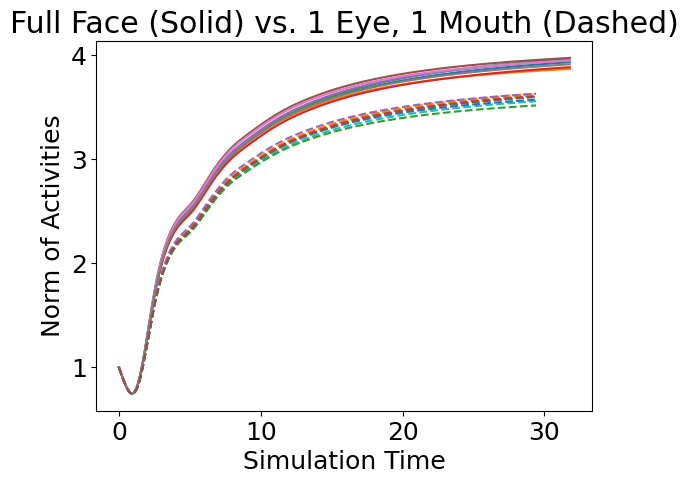

In [28]:
rows, cols = phase_space.shape
rows2, cols2 = phase_space2.shape

plt.figure()

plt.plot([args.test_lr*i for i in range(rows)], phase_space)

"""
plt.xlabel("Simulation Time")
plt.ylabel("Norm of Activities")
plt.title("Full Face")
plt.show()

plt.figure()
"""
plt.plot([args.test_lr*i for i in range(rows2)], phase_space2, ls="--")

plt.xlabel("Simulation Time")
plt.ylabel("Norm of Activities")
#plt.title("1 Eye, 1 Mouth")
plt.title("Full Face (Solid) vs. 1 Eye, 1 Mouth (Dashed)")
plt.show()

# Errors

In [29]:
conv_times = []
#print(conv_times)
acc = 0 
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

    label_preds, times, phase_space = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=5e-4, norm=args.test_convergence_norm, 
                                                     mu_dt=args.test_lr, norm_errors=True)
    
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
        elif False: #testing plotting
            conv_times.append(np.random.random())

    acc += utils.Want_accuracy(label_preds, label_batch)

#print(sorted(conv_times))
print(len(conv_times))

8


In [30]:
conv_times = []
#print(conv_times)
acc = 0 
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl2))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

    label_preds, times, phase_space2 = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=5e-4, norm=args.test_convergence_norm, 
                                                     mu_dt=args.test_lr, norm_errors=True)
    
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
        elif False: #testing plotting
            conv_times.append(np.random.random())

    acc += utils.Want_accuracy(label_preds, label_batch)

#print(sorted(conv_times))
print(len(conv_times))

8


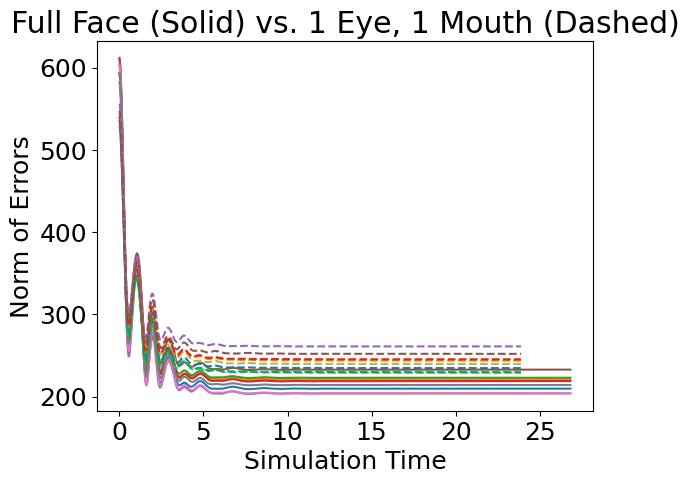

In [31]:
rows, cols = phase_space.shape
rows2, cols2 = phase_space2.shape

plt.figure()

plt.plot([args.test_lr*i for i in range(rows)], phase_space)

"""
plt.xlabel("Simulation Time")
plt.ylabel("Norm of Errors")
plt.title("Full Face")
plt.show()

plt.figure()
"""
plt.plot([args.test_lr*i for i in range(rows2)], phase_space2, ls="--")

plt.xlabel("Simulation Time")
plt.ylabel("Norm of Errors")
#plt.title("1 Eye, 1 Mouth")
plt.title("Full Face (Solid) vs. 1 Eye, 1 Mouth (Dashed)")
plt.show()